# Example with a complex mesh in 3d

In [147]:
# input data
size = Lx, Ly, Lz = (20, 0.5, 2)
F = -10  # value of the load at the free end
E = 12000.  # Young's mpdulus
nu = 0.2  # Poisson's ratio
R = 0.3  # radius of the circular beam CS

# oc parameters
volume_fraction = 0.4
ftol = 0.9
nIter = 200

# grid parameters
knn = True
resulution = (60, 2, 8)  # resolution of the result in all 3 directions
k = 18

In [148]:
import numpy as np

# material for beams
G = E / (2 * (1 + nu))
A = np.pi * R**2
Iy = Iz = 0.25 * np.pi * R**4
Ix = 0.5 * np.pi * R**4
HookeB2 = np.array([
    [E*A, 0, 0, 0],
    [0, G*Ix, 0, 0],
    [0, 0, E*Iy, 0],
    [0, 0, 0, E*Iz]
])

In [149]:
from polymesh.grid import gridH8 as grid, knngridL2
from polymesh.utils.topology import H8_to_L2

gridparams = {
    'size': size,
    'shape': resulution,
    'origo': (0, 0, 0),
    'start': 0
}
if knn:
    X, _ = grid(**gridparams)
    coords, topoB2 = knngridL2(X=X, k=k)
else:
    coords, topo = grid(**gridparams)
    _, topoB2 = H8_to_L2(coords, topo)

In [150]:
from neumann import repeat, minmax
from polymesh.space import PointCloud, StandardFrame
from polymesh.utils import cell_centers_bulk
from polymesh.utils.space import frames_of_lines, frames_of_surfaces
from sigmaepsilon import Structure, PointData, FemMesh
from sigmaepsilon.fem.cells import H8, B2, Q4_S_MR as Q4


# place the origo to the center of the cross section
# at the support
pc = PointCloud(coords)
pc.centralize()
dx = pc.bounds()[0, 0]
pc.move(np.array([-dx, 0., 0.]))
coords = pc.show()

# fix points at x==0
cond = coords[:, 0] <= 0.001
ebcinds = np.where(cond)[0]
fixity = np.zeros((coords.shape[0], 6), dtype=bool)
fixity[ebcinds, :] = True

# unit vertical load at (Lx, 0, 0)
iF = pc.index_of_closest([Lx, 0., 0.])
loads = np.zeros((coords.shape[0], 6))
loads[iF, 2] = F

# pointdata
GlobalFrame = StandardFrame(dim=3)
pd = PointData(coords=coords, frame=GlobalFrame,
               loads=loads, fixity=fixity)

# celldata
framesB2 = frames_of_lines(coords, topoB2)
cdB2 = B2(topo=topoB2, frames=framesB2, material=HookeB2, areas=A)

# set up mesh and structure
mesh = FemMesh(pd, frame=GlobalFrame)
mesh['B2'] = FemMesh(cdB2)
structure = Structure(mesh=mesh)


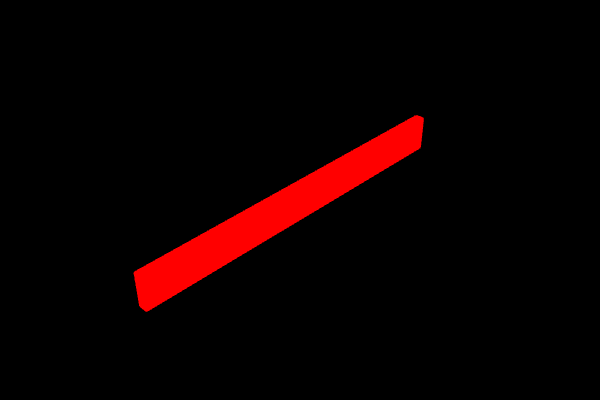

In [151]:
import pyvista as pv
from pyvista import themes

my_theme = themes.DarkTheme()
my_theme.lighting = False
my_theme.show_edges = True
my_theme.axes.box = True

mesh['B2'].config['pyvista', 'plot', 'color'] = 'red'
mesh['B2'].config['pyvista', 'plot', 'line_width'] = 1.5
mesh['B2'].config['pyvista', 'plot', 'render_lines_as_tubes'] = True

mesh.pvplot(notebook=True, jupyter_backend='static', theme=my_theme,
            window_size=(600, 400), config_key=('pyvista', 'plot'))


In [152]:
# solve
structure.linear_static_analysis()
dofsol = structure.nodal_dof_solution()
structure.mesh.pd['x'] = coords + dofsol[:, :3]


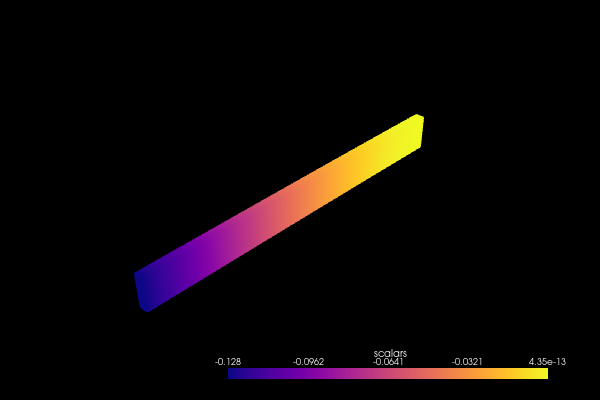

In [153]:
# plot
mesh.pvplot(notebook=True, window_size=(600, 400), cmap='plasma',
            config_key=('pyvista', 'plot'),
            theme=my_theme, jupyter_backend='static', scalars=dofsol[:, 2])


## Optimization

In [154]:
from sigmaepsilon.topopt.oc import maximize_stiffness
from linkeddeepdict import LinkedDeepDict
from tqdm import tqdm

history = LinkedDeepDict(dict(vol=[], obj=[], pen=[], x=[]))

In [155]:
# iteration parameters
OC_params = {
    'p_start': 1.0,  # SIMP penalty factor
    'p_inc': 0.0,
    'q': 0.5,  # smoothing factor
    'vfrac': volume_fraction,
    'dtol': 0.3,  # to control maximum change in the variables
    'miniter': 30,
    'maxiter': 1e12
}
optimizer = maximize_stiffness(structure, **OC_params)
r = next(optimizer)
history['obj'].append(r.obj)
history['vol'].append(r.vol)
history['pen'].append(r.pen)

In [156]:
for _ in tqdm(range(10)):
    r = next(optimizer)
    history['obj'].append(r.obj)
    history['vol'].append(r.vol)
    history['pen'].append(r.pen)

100%|██████████| 10/10 [00:03<00:00,  2.99it/s]


In [157]:
# iteration parameters
OC_params = {
    'p_start': 1.0,  # SIMP penalty factor
    'p_stop': 3.0,
    'p_inc': 0.2,
    'p_step': 5,
    'q': 0.5,  # smoothing factor
    'vfrac': volume_fraction,
    'dtol': 0.1,  # to control maximum change in the variables
    'miniter': 30,
    'maxiter': 1e12,
}
OC_params['neighbours'] = structure.mesh.k_nearest_cell_neighbours(1)
optimizer = maximize_stiffness(structure, guess=r.x, i_start=r.n + 1, **OC_params)
for _ in tqdm(range(nIter)):
    r = next(optimizer)
    history['obj'].append(r.obj)
    history['vol'].append(r.vol)
    history['pen'].append(r.pen)

100%|██████████| 200/200 [01:10<00:00,  2.83it/s]


## Postprocessing

In [158]:
from polymesh.utils.topology import detach

i = np.where(r.x >= ftol)[0]
coords = mesh.coords()
topoB2 = mesh.topology()
coords, topoB2 = detach(coords, topoB2[i])

In [159]:
from polymesh.utils.space import index_of_closest_point

pc = PointCloud(coords)
pc.centralize()
dx = pc.bounds()[0, 0]
pc.move(np.array([-dx, 0., 0.]))
coords = pc.show()

# fix points at x==0
cond = coords[:, 0] <= 0.001
ebcinds = np.where(cond)[0]
fixity = np.zeros((coords.shape[0], 6), dtype=bool)
fixity[ebcinds, :] = True

# unit vertical load at (Lx, 0, 0)
iF = pc.index_of_closest([Lx, 0., 0.])
loads = np.zeros((coords.shape[0], 6))
loads[iF, 2] = F

# pointdata
GlobalFrame = StandardFrame(dim=3)
pd = PointData(coords=coords, frame=GlobalFrame,
               loads=loads, fixity=fixity)

# celldata
framesB2 = frames_of_lines(coords, topoB2)
cdB2 = B2(topo=topoB2, frames=framesB2, material=HookeB2, areas=A)

# set up mesh and structure
mesh = FemMesh(pd, frame=GlobalFrame)
mesh['B2'] = FemMesh(cdB2)
structure = Structure(mesh=mesh)

structure.linear_static_analysis()
dofsol = structure.nodal_dof_solution()

In [ ]:
# plot
structure.mesh.pd['x'] = coords + dofsol[:, :3]
mesh.pvplot(notebook=False, window_size=(600, 400), cmap='plasma',
            config_key=('pyvista', 'plot'),
            theme=my_theme, scalars=dofsol[:, 2])
